In [1]:
import cv2, os
import numpy as np
from keras import utils,layers,models,optimizers
from keras.utils import plot_model
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.layers import Dense,Dropout,Activation,Flatten
import seaborn as sn
import tensorflow as tf
import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
train_path="images/train"
val_path="images/validation"
train_data_list= os.listdir(train_path)
val_data_list= os.listdir(val_path)

In [3]:
train_data_list

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
def Data_prepare(data_list,path):
  img_data=[]
  for dataset in data_list:
    img_list=os.listdir(path + "/" + dataset)
    subfolder_path = os.path.join(path, dataset)
    num_items = len([item for item in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, item))])
    print(f"Loading The images from the folder {dataset}, {num_items} images")
    for img in img_list:
      input_img= cv2.imread(path+"/"+dataset+"/"+img)
      input_img_resized= cv2.resize(input_img,(96,96))
      img_data.append(input_img_resized)
  data=np.array(img_data)
  data=data.astype("float32")
  data=data/255.0
  return data

In [5]:
train_data=Data_prepare(train_data_list,train_path)

Loading The images from the folder angry, 3993 images
Loading The images from the folder disgust, 436 images
Loading The images from the folder fear, 4103 images
Loading The images from the folder happy, 7164 images
Loading The images from the folder neutral, 4982 images
Loading The images from the folder sad, 4938 images
Loading The images from the folder surprise, 3205 images


In [6]:
val_data=Data_prepare(val_data_list,val_path)

Loading The images from the folder angry, 960 images
Loading The images from the folder disgust, 111 images
Loading The images from the folder fear, 1018 images
Loading The images from the folder happy, 1825 images
Loading The images from the folder neutral, 1216 images
Loading The images from the folder sad, 1139 images
Loading The images from the folder surprise, 797 images


In [7]:
num_classes= 7
num_train_samples=train_data.shape[0]
num_val_samples=val_data.shape[0]
print(f"Train data shape :{train_data.shape}")
print(f"Validation data shape :{val_data.shape}")

Train data shape :(28821, 96, 96, 3)
Validation data shape :(7066, 96, 96, 3)


In [8]:
# One hot vector -> Labels
train_labels=np.ones((num_train_samples,),dtype="int64")
train_labels[0:3205] = 0 # -> Surprise
train_labels[3205:7308] = 1 # -> Fear
train_labels[7308:11301] = 2 # -> Angry
train_labels[11301:16283] = 3 # -> Netural
train_labels[16283:21221] = 4 # -> Sad
train_labels[21221:21657] = 5 # -> Disgust
train_labels[21657:28821] = 6 # -> Happy
img_train_labels=utils.to_categorical(train_labels,num_classes)


val_labels=np.ones((num_val_samples,),dtype="int64")
val_labels[0:797] = 0 # -> Surprise
val_labels[797:1815] = 1 # -> Fear
val_labels[1815:2775] = 2 # -> Angry
val_labels[2775:3991] = 3 # -> Netural
val_labels[3991:5130] = 4 # -> Sad
val_labels[5130:5214] = 5 # -> Disgust
val_labels[5214:7066] = 6 # -> Happy
img_val_labels=utils.to_categorical(val_labels,num_classes)

In [9]:
img_train_labels[12000]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [10]:
# Shuffle
X_train,Y_train=shuffle(train_data,img_train_labels,random_state=5)
X_test,Y_test=shuffle(val_data,img_val_labels,random_state=5)

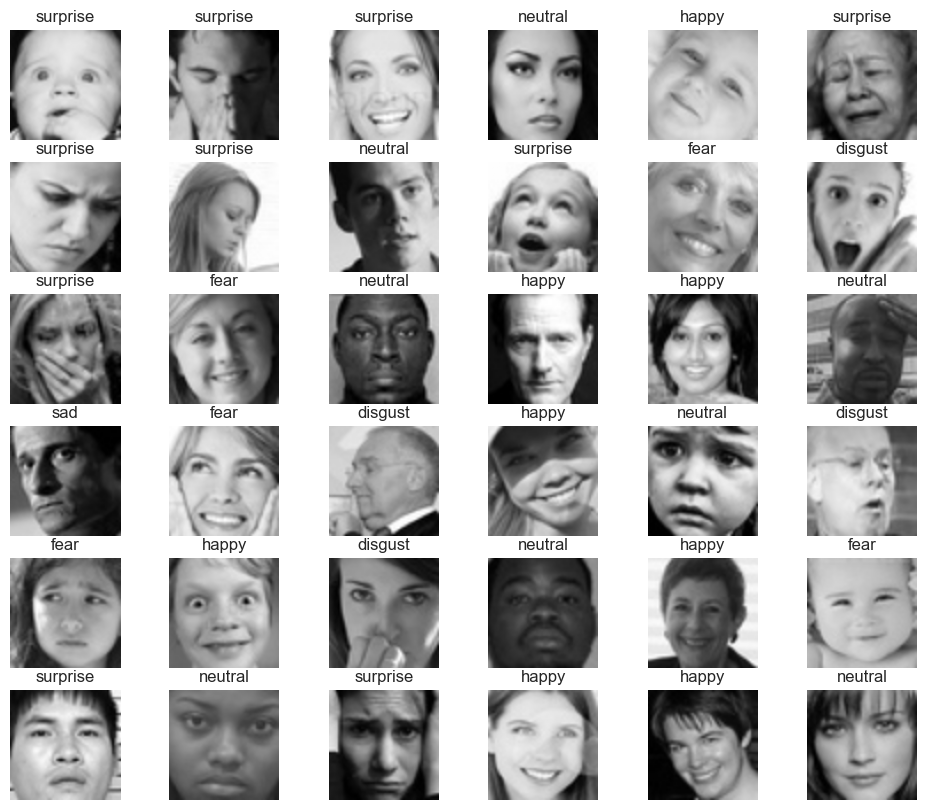

In [11]:
plt.figure(figsize=(12,10))
for i,j in enumerate(list(np.random.randint(0,len(X_train),36))): # index,item
  plt.subplot(6,6,i+1)
  plt.imshow(X_train[j])
  plt.axis("off")
  plt.title(train_data_list[list(Y_train[j].astype(int)).index(1)])

In [12]:
MobileNetV2_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
MobileNetV2_model.summary()



Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1

In [13]:
model = models.Sequential()
model.add(MobileNetV2_model)
layers.Dropout(0.4)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
layers.Dropout(0.25)
model.add(layers.Dense(64, activation='relu'))
layers.Dropout(0.25)
model.add(layers.Dense(7, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 128)               1474688   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 3741383 (14.27 MB)
Trainable params: 3707271 (14.14 MB)
Non-trainable params: 34112 (133.25 KB)
____________

In [15]:
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
            )

In [47]:
model.fit(X_train,Y_train,epochs=50,validation_data=(X_test,Y_test))

Epoch 1/50
901/901 [==============================] - 139s 149ms/step - loss: 0.4659 - accuracy: 0.8104 - val_loss: 2.2199 - val_accuracy: 0.4513
Epoch 2/50
901/901 [==============================] - 136s 151ms/step - loss: 0.4451 - accuracy: 0.8154 - val_loss: 2.3884 - val_accuracy: 0.4669
Epoch 3/50
901/901 [==============================] - 138s 153ms/step - loss: 0.4333 - accuracy: 0.8213 - val_loss: 2.3697 - val_accuracy: 0.4628
Epoch 4/50
901/901 [==============================] - 136s 150ms/step - loss: 0.4137 - accuracy: 0.8303 - val_loss: 2.2339 - val_accuracy: 0.4858
Epoch 5/50
901/901 [==============================] - 130s 144ms/step - loss: 0.4044 - accuracy: 0.8328 - val_loss: 2.3868 - val_accuracy: 0.4636
Epoch 6/50
901/901 [==============================] - 129s 143ms/step - loss: 0.3826 - accuracy: 0.8424 - val_loss: 2.4993 - val_accuracy: 0.4860
Epoch 7/50
901/901 [==============================] - 129s 143ms/step - loss: 0.3770 - accuracy: 0.8469 - val_loss: 2.4000 -

In [54]:
# Saving the model
model.save("my_model.h5")
model.save("my_model.keras")

D:\MyWork\DataScience\HRChatBot\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - 7s 33ms/step


Text(95.72222222222221, 0.5, 'Truth')

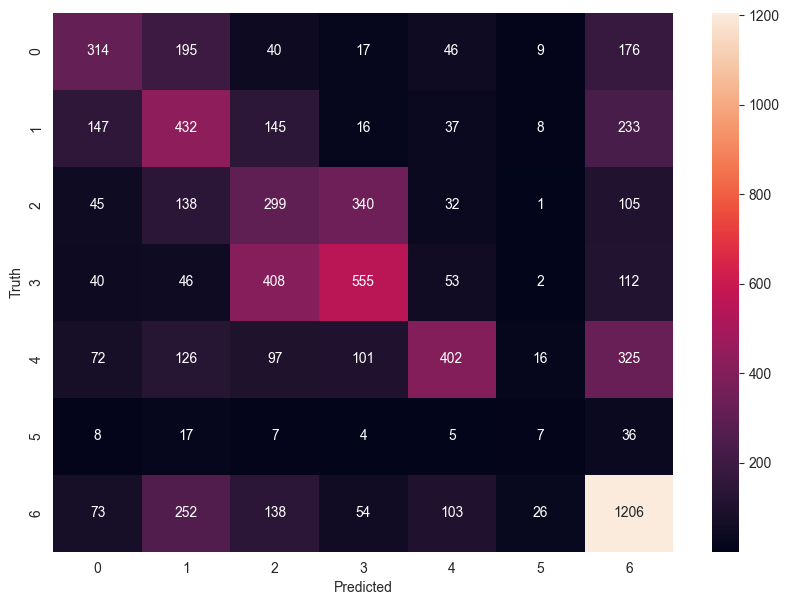

In [49]:
y_pred = model.predict(X_test)
y_pred_labels=[np.argmax(element) for element in y_pred]#returns the index of the highest probability.
y_test_labels=[np.argmax(element) for element in Y_test]
cm = tf.math.confusion_matrix(labels=y_test_labels,predictions=y_pred_labels)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
from sklearn.metrics import accuracy_score

# Assuming y_test_labels and y_pred_labels are available
accuracy = accuracy_score(y_test_labels, y_pred_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')
# Assuming you have a trained model named 'model' and a test dataset (X_test)
y_pred_probabilities = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)


Accuracy: 45.50%
221/221 [==============================] - 7s 30ms/step


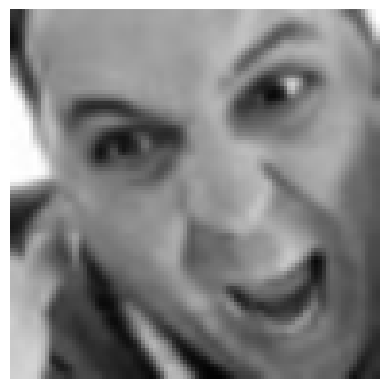

Predicted: Surprise, Actual: Surprise


In [59]:
from IPython.display import clear_output
import time

label_to_text = {0:'Surprise', 1:'Fear', 2:'Angry', 3:'Neutral', 4: 'Sad', 5: 'Disgust', 6: 'Happy'}
num_images_to_display = 10
display_time = 3
random_indices = np.random.choice(len(X_test), num_images_to_display, replace=False)

for i in random_indices:
    # Display the image
    plt.imshow(X_test[i])  
    plt.axis('off')
    plt.show()

    # Output predicted and actual labels
    print(f"Predicted: {label_to_text[y_pred_labels[i]]}, Actual: {label_to_text[y_test_labels[i]]}")

    # Wait for a few seconds before displaying the next image
    time.sleep(display_time)
    
    # Clear the output to show the next image cleanly
    clear_output(wait=True)




1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


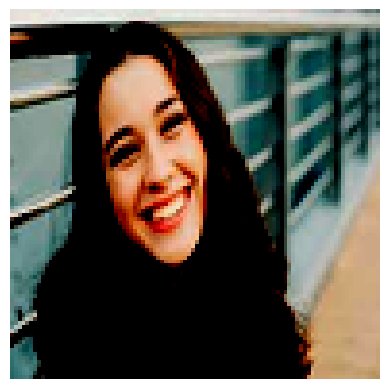

Predicted: Happy


In [1]:
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_image_for_mobilenet_v2(image_path, target_size=(96, 96)):
    img = Image.open(image_path)
    # Resize the image to the target size
    img = img.resize(target_size, resample=Image.LANCZOS)

    # Convert PIL image to NumPy array
    img_array = np.array(img)

    # If the image is grayscale, repeat the channel to create an RGB image
    if len(img_array.shape) == 2:
        img_array = np.repeat(img_array[:, :, np.newaxis], 3, axis=-1)

    # Preprocess the image for MobileNetV2
    img_array = preprocess_input(img_array)

    return img_array

label_to_text = {0: 'Surprise', 1: 'Fear', 2: 'Angry', 3: 'Neutral', 4: 'Sad', 5: 'Disgust', 6: 'Happy'}
num_images_to_display = 30
display_time = 3

# Load your trained model (replace 'YourModel.h5' with your actual model file)
model = load_model('my_model.h5')

# Insert the path to the image you want to predict
image_path = "img.png"

# Preprocess the image for prediction
image = preprocess_image_for_mobilenet_v2(image_path)  # You can use the previously defined preprocessing function

# Make predictions using the model
prediction = model.predict(np.expand_dims(image, axis=0))

# Get the predicted label
predicted_label = label_to_text[np.argmax(prediction)]

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Output predicted label
print(f"Predicted: {predicted_label}")

# Wait for a few seconds before clearing the output
time.sleep(display_time)
clear_output(wait=True)
